# Using a K-nearest Neighbours Classifier To Detect Bank Account Opening Fraud
### 2022W2 DSCI 100 Group Project Report

Team Members:
- Aqil Faizal
- Andrei Chepakovich
- Jiaying Ong
- Lucy Liu

## Introduction
Fraud is a major problem in Canada, with a total of $531M being lost to fraud in 2022 according to the Canadian Anti-Fraud Centre. Although overall rates of digital financial fraud in Canada have fallen in recent years, identity theft rates have been on the rise. According to Statista, an online platform for consumer data, identity fraud rates in Canada has consistently grown from 2008 to 2021 and sat at 61.95 per 100,000 residents in the latter year. Identity thieves commonly involve stealing personal information to create new bank accounts and performing fraudulent activities such as credit card fraud, fraudulent loan applications, and money laundering. This act is known as account opening fraud, and will be the focus of this group project.

In this project, we aim to use the R tidymodels framework to build a K-nearest neighbours classifier that can classify a bank account as fraudulent or non-fraudulent. The data being used is from the Bank Account Fraud suite of datasets published at NeurIPS 2022, a machine learning conference. This synthetic dataset is based on real-world bank account data. The main questions that we would like to answer in this project are: 

1) Given this data, can we use the K-nearest neighbours algorithm to classify a bank account as fraudulent or non-fraudulent with reasonable accuracy, and 

2) Which variables are good indicators of account opening fraud?

## Description of the dataset
We used the Base.csv dataset from the aforementioned Bank Account Fraud suite, which has 32 variables and 1M observations. As the K-nearest neighbours algorithm becomes computationally costly with a large number of observations, we first **randomly sampled 100,000 rows of data** and then filtered this subset further to obtain only observations with certain attributes.

We also plan to use the forward selection algorithm to select the predictor variables to be used by the KNN model. Since using many variables for forward selection involves the training of many models and increases the chance that we come across a model with a high cross-validation accuracy estimate, but a low true accuracy on the test data, we **first examined 6 variables** that we felt were most likely to be the indicators of fraudulence.

## Methods

### 1. Loading required libraries and data from the web:

The required libraries for running the code in this report are:

- tidyverse
- repr
- tidymodels
- themis
- kknn
- cowplot

In [1]:
### Setup
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
library(kknn)
library(cowplot)

options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.5     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Since the dataset has 1 million rows, we first **downloaded Base.csv locally** and **randomly sampled 100,000 rows**, which we then wrote to a .csv file and hosted on Google Sheets. We then read the data in again from Google Sheets:

In [2]:
fraud_data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRL6hq0R8gYhL5VhHlCOGGSKTea3N54QsEC8zcr5pHwuY2Ly5Zc6G83araSMkzwQF7suK_o6tr-4MEP/pub?output=csv")|>
mutate(fraud_bool=as_factor(fraud_bool))

fraud_data

Rows: 100000 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): payment_type, employment_status, housing_status, source, device_os
dbl (27): fraud_bool, income, name_email_similarity, prev_address_months_cou...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,⋯,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9,0.16682773,-1,88,50,0.020925173,-1.3313450,AA,769,⋯,0,500,0,INTERNET,3.888115,windows,0,1,0,7
1,0.9,0.29628601,-1,144,50,0.005417538,-0.8162238,AB,366,⋯,0,1500,0,INTERNET,31.798819,windows,0,1,0,7
1,0.9,0.04498549,-1,132,40,3.108548793,-0.7557277,AC,870,⋯,0,200,0,INTERNET,4.728705,other,0,1,0,7
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,0.6,0.8435506,-1,18,40,0.01090603,-0.8543749,AB,602,⋯,0,1500,0,INTERNET,5.939641,other,1,1,0,3
0,0.4,0.6882371,-1,50,20,0.02786849,50.3059704,AA,691,⋯,0,500,0,INTERNET,3.273092,linux,1,1,0,3
0,0.7,0.7537215,-1,50,30,0.02482313,98.5380625,AA,878,⋯,1,500,0,INTERNET,6.452148,windows,0,1,0,3


### 2. Narrowing down to potential predictor variables and filtering for certain characteristics

We then narrowed the dataset down to the 6 variables which we felt are most likely to be indicators of fraudulence, as well as the label to be predicted (whether the bank account is fraudulent): 

- Credit risk score: credit risk score of the applicant. Ranges between [383, -147]
- Income: Annual income of the applicant in quantiles. Ranges between [0.1, 0.9].
- Months lived at current address: time applicant has lived at current address in months. Ranges between [-1, 399].
- Name-email similarity: Metric of similarity between email and applicant’s name. Higher values represent higher similarity. Ranges between [3.83e-05, 0.9999957].
- Session length in minutes: unknown. Ranges between [-1, 83.37677].
- Proposed credit limit: proposed credit limit of the applicant. Ranges between [190, 2100].
- Fraud_bool: Fraud label (1 if fraud, 0 if legitimate).

In addition, we also filtered for observations with the following characteristics:

- From the month of July
- With the employment status of 'CA' 
- With the housing status of 'BA'

Since the dataset is synthetic, the employment and housing statuses have arbitrary meaning. 

**Observing ranges of the potential predictor variables**

In [3]:
range_credit_risk_score = fraud_data |>
    summarize(max = max(credit_risk_score), min = min(credit_risk_score))

range_credit_risk_score

range_income = fraud_data |>
    summarize(max = max(income), min = min(income))

range_income

range_current_address_months_count = fraud_data |>
    summarize(max = max(current_address_months_count), min = min(current_address_months_count))

range_current_address_months_count

range_name_email_similarity = fraud_data |>
    summarize(max = max(name_email_similarity), min = min(name_email_similarity))

range_name_email_similarity

range_session_length_in_minutes = fraud_data |>
    summarize(max = max(session_length_in_minutes), min = min(session_length_in_minutes))

range_session_length_in_minutes

range_proposed_credit_limit = fraud_data |>
    summarize(max = max(proposed_credit_limit), min = min(proposed_credit_limit))

range_proposed_credit_limit

max,min
<dbl>,<dbl>
383,-147


max,min
<dbl>,<dbl>
0.9,0.1


max,min
<dbl>,<dbl>
399,-1


max,min
<dbl>,<dbl>
0.9999957,3.83e-05


max,min
<dbl>,<dbl>
83.37677,-1


max,min
<dbl>,<dbl>
2100,190


**Filtering so only potential predictor variables left and for rows with certain characteristics**

In [4]:
set.seed(9999)

fraud_narrowed <- fraud_data |>
    filter(month == 7, employment_status == "CA", housing_status == "BA") |>
    select(fraud_bool, credit_risk_score, income, current_address_months_count, name_email_similarity, session_length_in_minutes, proposed_credit_limit)    
fraud_narrowed

fraud_bool,credit_risk_score,income,current_address_months_count,name_email_similarity,session_length_in_minutes,proposed_credit_limit
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,185,0.9,88,0.1668277,3.888115,500
1,259,0.9,144,0.2962860,31.798819,1500
1,110,0.9,22,0.1595112,2.047904,200
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,179,0.9,134,0.6891395,2.310369,500
0,234,0.9,3,0.5094120,2.943703,1000
0,244,0.8,131,0.8623505,4.555719,1500


### 3. Data cleaning and splitting of dataset

Firstly, we cleaned our data to remove observations with -1 for the "months lived at current address" and "session length in minutes" variables, since it is likely that -1 does not actually denote a value of -1 and instead denotes that the value was not available.

**Cleaning data so potential predictor variable columns no longer contain -1 values**

In [5]:
fraud_narrowed <- fraud_narrowed |>
    filter(current_address_months_count != -1, session_length_in_minutes != -1)

fraud_narrowed

fraud_bool,credit_risk_score,income,current_address_months_count,name_email_similarity,session_length_in_minutes,proposed_credit_limit
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,185,0.9,88,0.1668277,3.888115,500
1,259,0.9,144,0.2962860,31.798819,1500
1,110,0.9,22,0.1595112,2.047904,200
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,179,0.9,134,0.6891395,2.310369,500
0,234,0.9,3,0.5094120,2.943703,1000
0,244,0.8,131,0.8623505,4.555719,1500


Then, we split the dataset into two datasets, a training dataset and a testing dataset. We did this so that we could accurately evaluate our final classification model using testing data it had not yet seen.

**Splitting dataset into training and testing datasets**

In [6]:
fraud_split <- initial_split(fraud_narrowed, prop = 0.75, strata = fraud_bool)
fraud_train <- training(fraud_split)
fraud_test <- testing(fraud_split) 

fraud_train
fraud_test 

number_of_rows <- nrow(fraud_train)
number_of_rows

fraud_bool,credit_risk_score,income,current_address_months_count,name_email_similarity,session_length_in_minutes,proposed_credit_limit
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,185,0.9,88,0.1668277,3.888115,500
1,259,0.9,144,0.2962860,31.798819,1500
1,295,0.9,218,0.5964137,3.775225,1500
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,46,0.8,137,0.02774166,2.463003,200
0,179,0.9,134,0.68913946,2.310369,500
0,234,0.9,3,0.50941196,2.943703,1000


fraud_bool,credit_risk_score,income,current_address_months_count,name_email_similarity,session_length_in_minutes,proposed_credit_limit
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,110,0.9,22,0.1595112,2.047904,200
1,220,0.9,162,0.6115532,3.531939,200
1,143,0.9,186,0.1254526,3.070971,200
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,213,0.4,371,0.80050226,34.566322,1500
0,266,0.4,141,0.02963662,5.247373,1000
0,244,0.8,131,0.86235045,4.555719,1500


[1] 11471

### 4. Exploratory data analysis

We were left with 11471 rows of training data. 

Next, we visualised the distribution of fraudulence among newly opened accounts and the distribution of the 6 potential predictor variables (to determine whether they could be used to predict account opening fraud).

**Distribution of Fraudulence**

fraud_bool,count,percentage
<fct>,<int>,<dbl>
0,10871,94.769419
1,600,5.230581


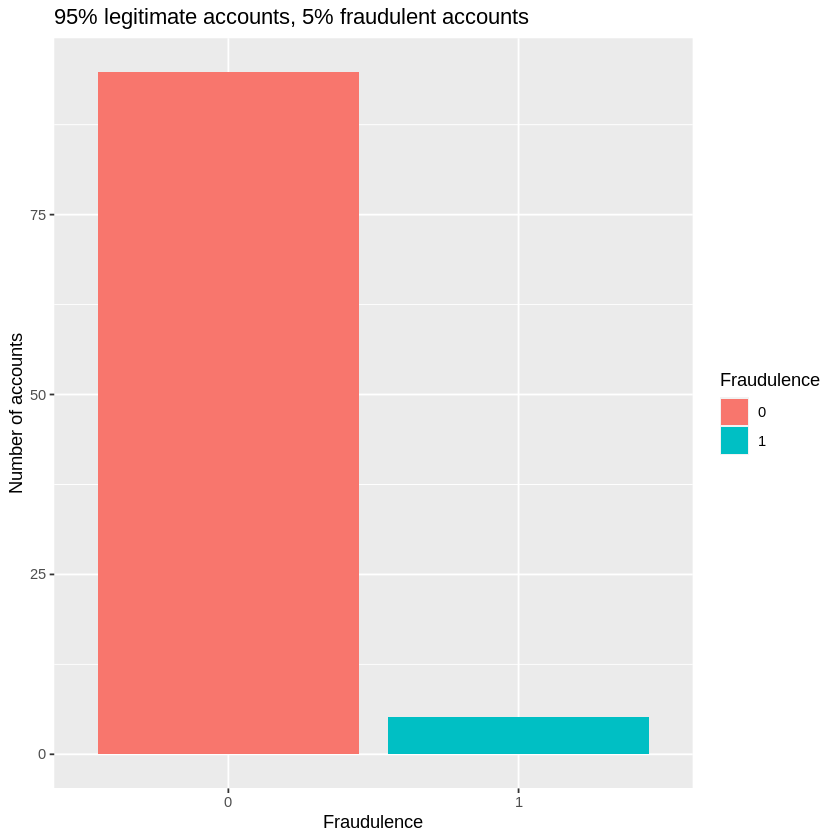

In [7]:
fraud_ratio_train <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(count = n()) 

fraud_percentages <- fraud_ratio_train |>
    mutate(percentage = (count / number_of_rows) * 100)

fraud_percentages_plot <- fraud_percentages |>
    ggplot(aes(x = fraud_bool, y = percentage, fill = fraud_bool)) +
    geom_bar(stat = "identity") +
    xlab("Fraudulence") +
    ylab("Number of accounts") +
    labs(fill = "Fraudulence") + 
    ggtitle("95% legitimate accounts, 5% fraudulent accounts")

fraud_percentages
fraud_percentages_plot

**Distribution of Credit Risk Score**

fraud_bool,credit
<fct>,<dbl>
0,180.4018
1,207.4300


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



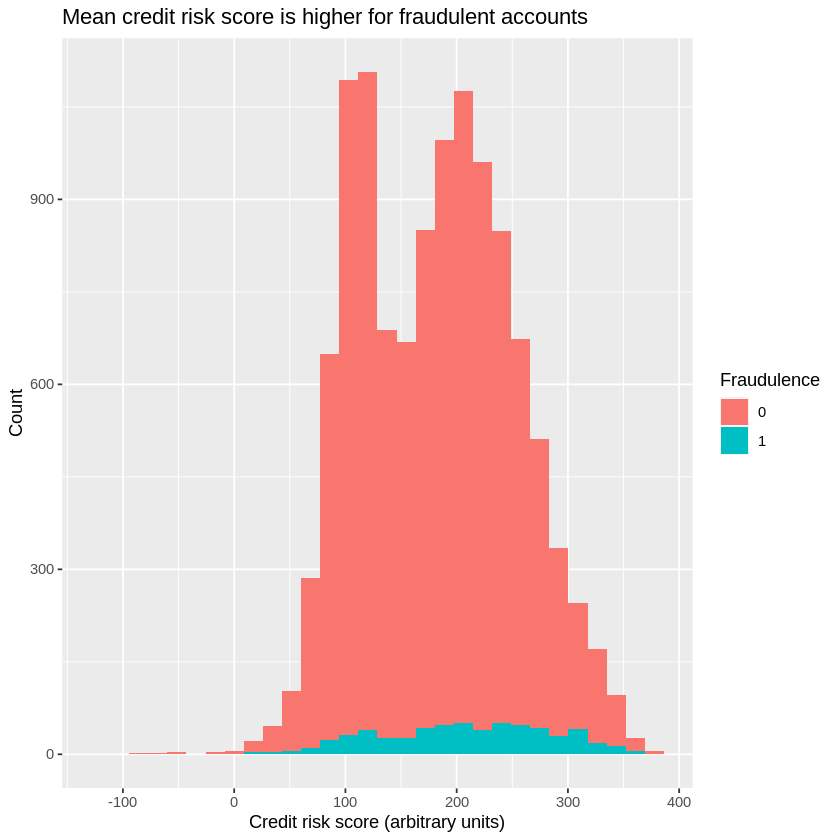

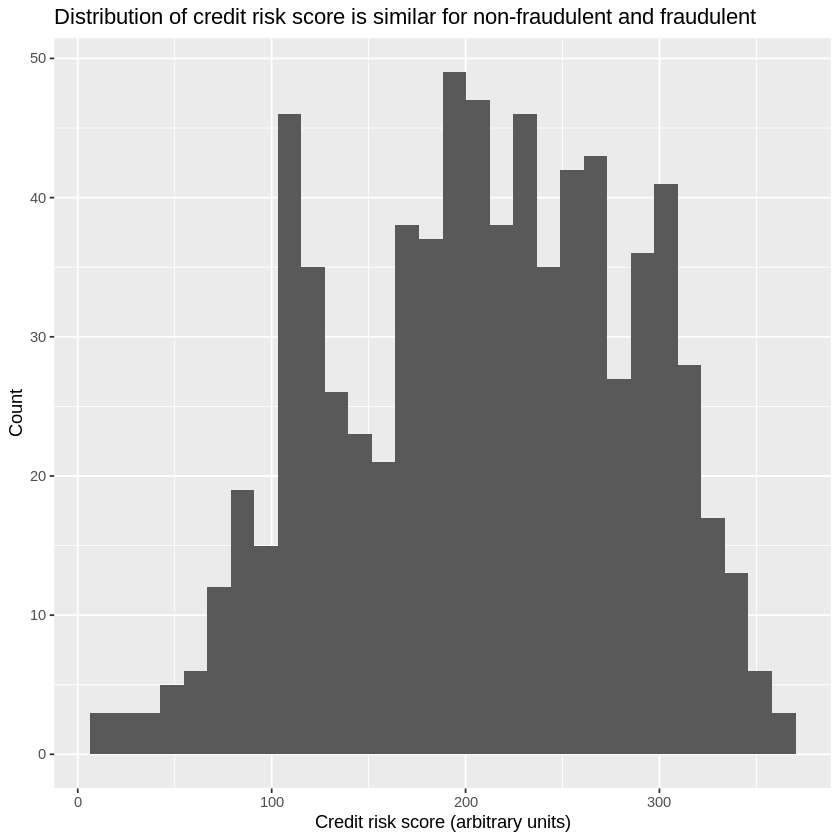

In [8]:
average_credit_risk_score <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(credit = mean(credit_risk_score))

average_credit_risk_score

credit_risk_score_plot <- ggplot(fraud_train, aes(x = credit_risk_score, fill = fraud_bool)) +
  geom_histogram() +
  labs(fill = "Fraudulence") +
  xlab("Credit risk score (arbitrary units)") +
  ylab("Count")+
  ggtitle("Mean credit risk score is higher for fraudulent accounts")

fraud_credit_risk_score_plot <- fraud_narrowed |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = credit_risk_score)) +
  geom_histogram() +
  xlab("Credit risk score (arbitrary units)") +
  ylab("Count") + 
  ggtitle("Distribution of credit risk score is similar for non-fraudulent and fraudulent")

credit_risk_score_plot
fraud_credit_risk_score_plot

**Distribution of Annual Income**

fraud_bool,income
<fct>,<dbl>
0,0.6937816
1,0.7373333


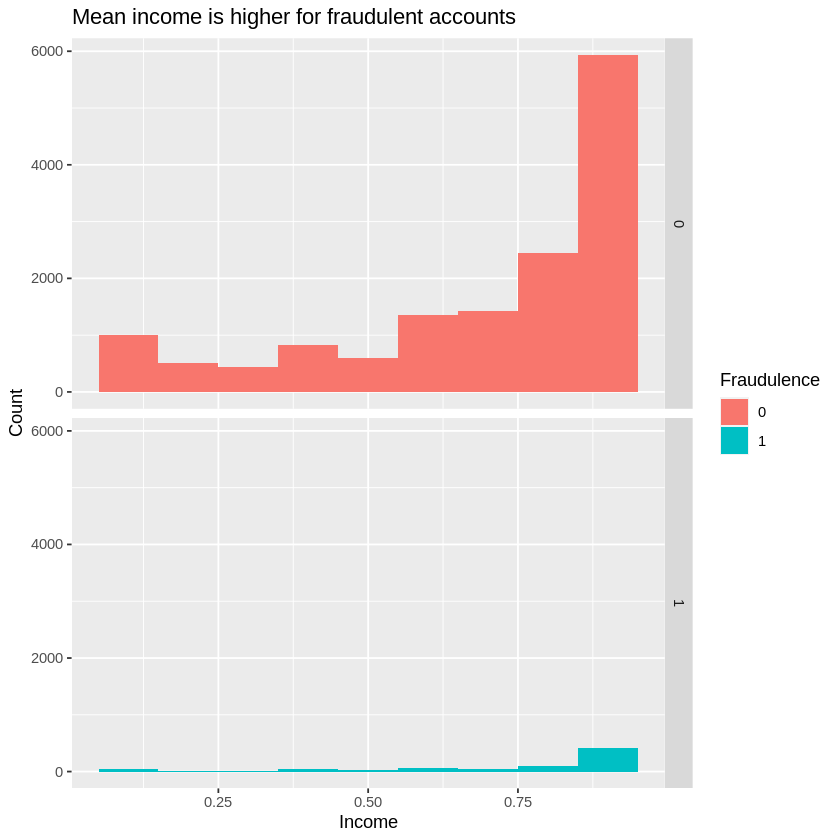

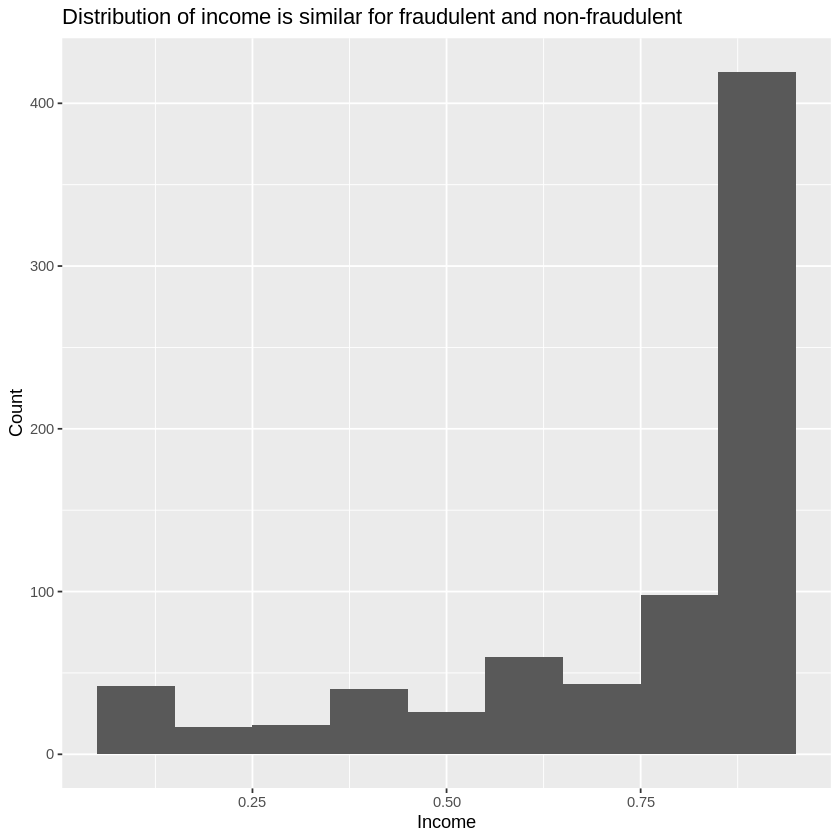

In [9]:
average_income <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(income = mean(income))

average_income

income_plot <- ggplot(fraud_narrowed, aes(x = income, fill = fraud_bool)) +
  geom_histogram(binwidth = 0.1) +
  labs(fill = "Fraudulence") +
  xlab("Income") +
  ylab("Count") +
  facet_grid(rows = vars(fraud_bool)) +
  ggtitle("Mean income is higher for fraudulent accounts")

fraud_income_plot <- fraud_narrowed |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = income)) +
  geom_histogram(binwidth = 0.1) +
  xlab("Income") +
  ylab("Count") + 
  ggtitle("Distribution of income is similar for fraudulent and non-fraudulent")
  

income_plot
fraud_income_plot

**Distribution of Months Lived at Current Address**

fraud_bool,address
<fct>,<dbl>
0,108.0709
1,112.6183


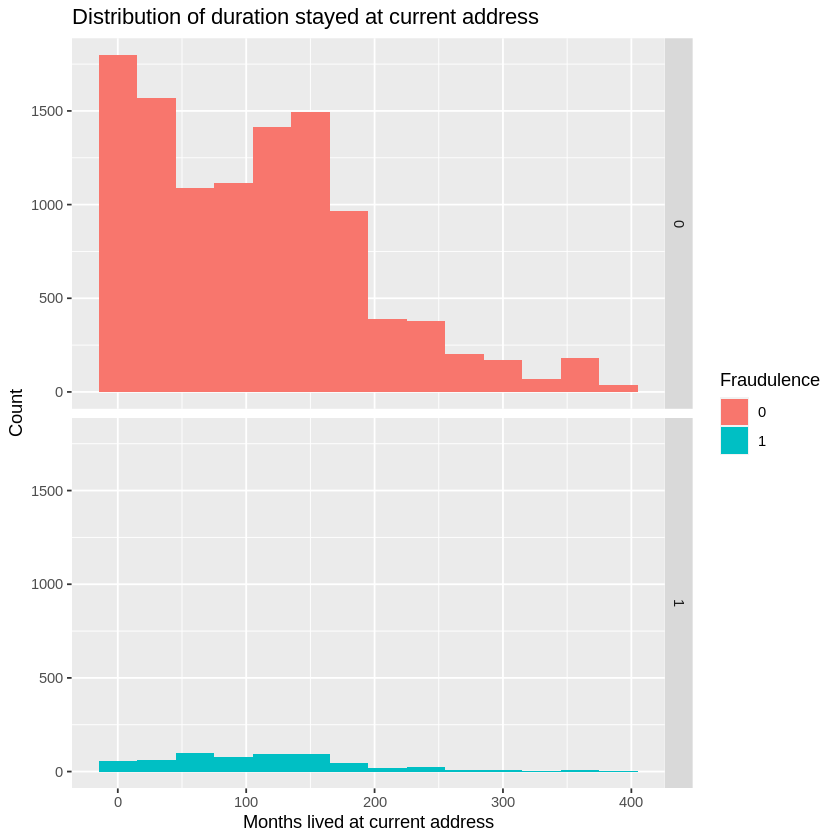

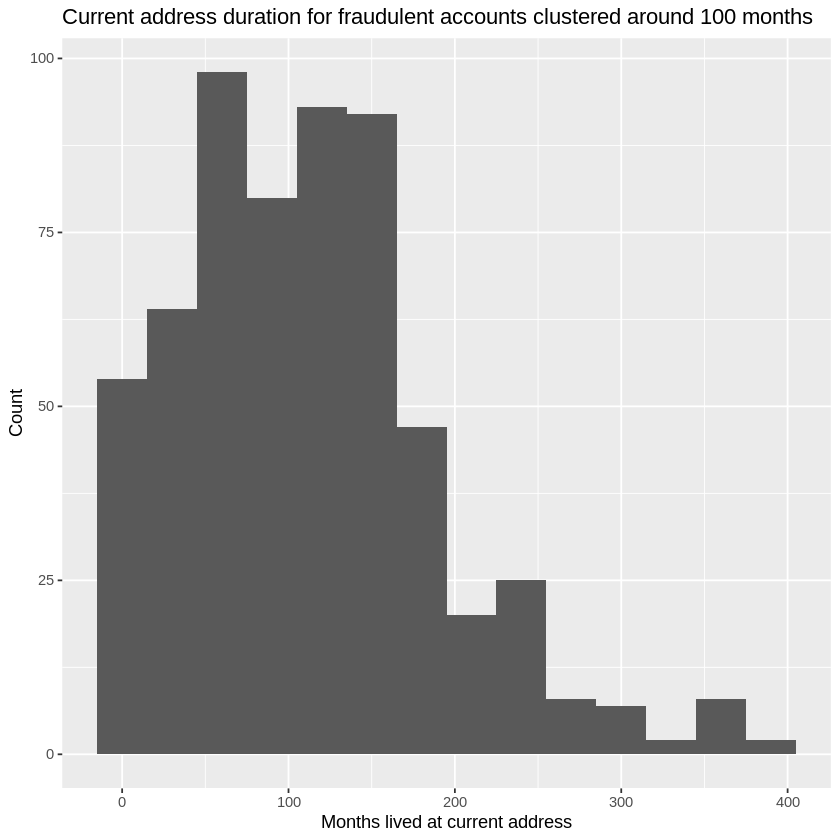

In [10]:
average_address_duration <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(address = mean(current_address_months_count))

average_address_duration

address_duration_plot <- ggplot(fraud_train, aes(x = current_address_months_count, fill = fraud_bool)) +
  geom_histogram(binwidth = 30) +
  labs(fill = "Fraudulence") +
  xlab("Months lived at current address") +
  ylab("Count") +
  facet_grid(rows = vars(fraud_bool)) +
  ggtitle("Distribution of duration stayed at current address")

fraud_address_duration <- fraud_train |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = current_address_months_count)) +
  geom_histogram(binwidth = 30) +
  xlab("Months lived at current address") +
  ylab("Count") +
  ggtitle("Current address duration for fraudulent accounts clustered around 100 months")

address_duration_plot
fraud_address_duration

**Distribution of Name-Email Similarity**

fraud_bool,similarity
<fct>,<dbl>
0,0.4964460
1,0.3986587


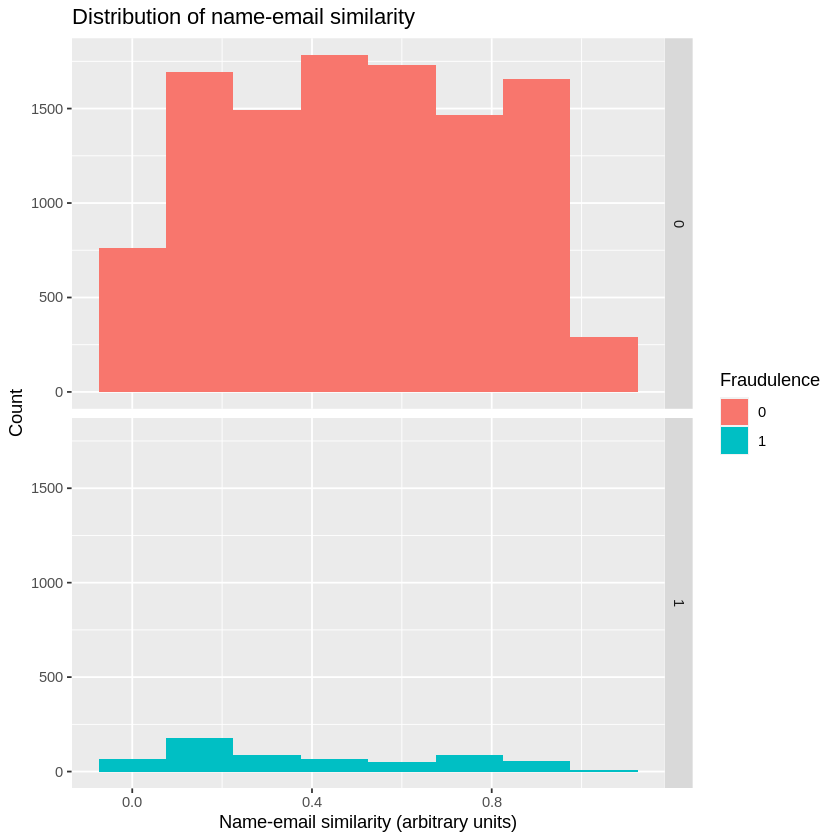

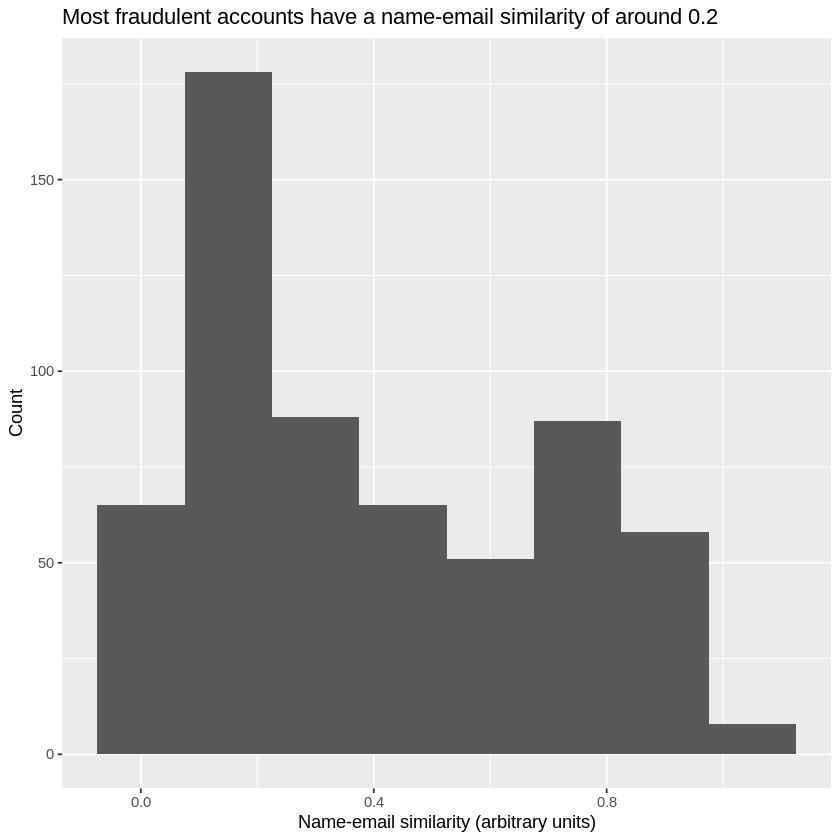

In [11]:
average_similarity <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(similarity = mean(name_email_similarity))

average_similarity 

similarity_plot <- ggplot(fraud_train, aes(x = name_email_similarity, fill = fraud_bool)) +
  geom_histogram(binwidth = 0.15) +
  labs(fill = "Fraudulence") +
  xlab("Name-email similarity (arbitrary units)") +
  ylab("Count") +
  facet_grid(rows = vars(fraud_bool)) +
  ggtitle("Distribution of name-email similarity")

fraud_similarity_duration <- fraud_train |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = name_email_similarity)) +
  geom_histogram(binwidth = 0.15) +
  xlab("Name-email similarity (arbitrary units)") +
  ylab("Count") +
  ggtitle("Most fraudulent accounts have a name-email similarity of around 0.2")

similarity_plot
fraud_similarity_duration

**Distribution of Session Lengths**

fraud_bool,session_length
<fct>,<dbl>
0,5.850821
1,6.754736


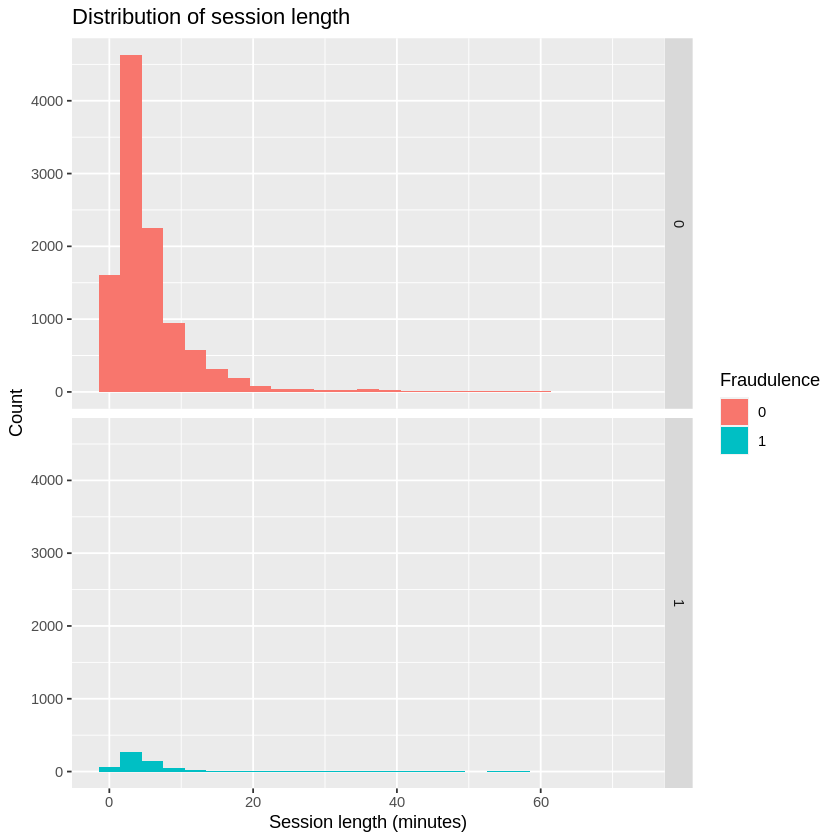

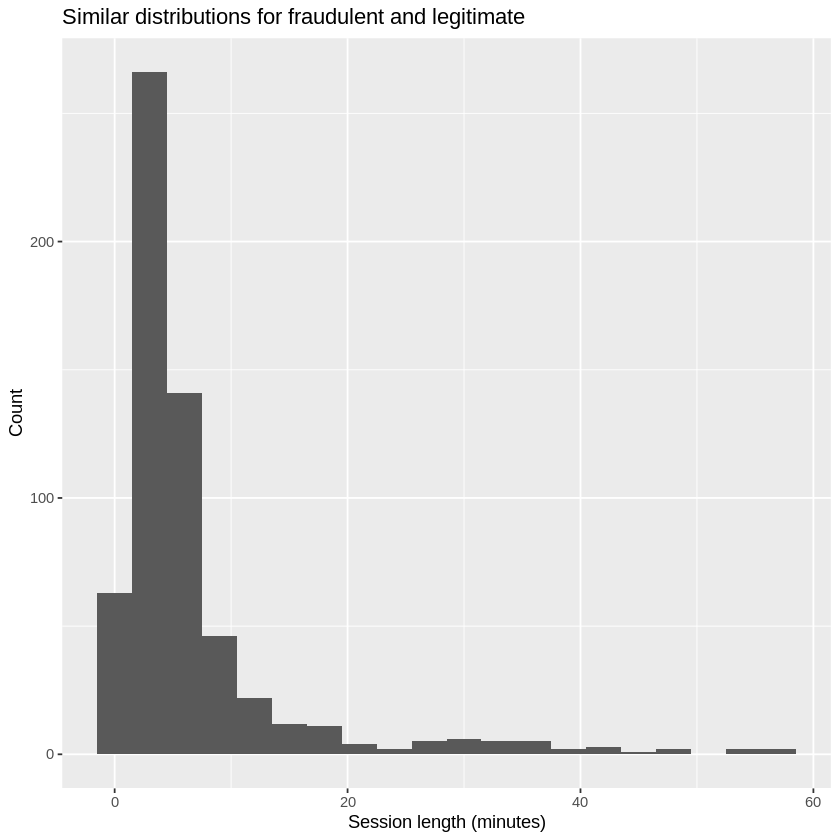

In [12]:
average_session <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(session_length = mean(session_length_in_minutes))

average_session

session_plot <- ggplot(fraud_train, aes(x = session_length_in_minutes, fill = fraud_bool)) +
  geom_histogram(binwidth = 3) +
  labs(fill = "Fraudulence") +
  xlab("Session length (minutes)") +
  ylab("Count") +
  facet_grid(rows = vars(fraud_bool)) +
  ggtitle("Distribution of session length")

fraud_session_duration <- fraud_train |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = session_length_in_minutes)) +
  geom_histogram(binwidth = 3) +
  xlab("Session length (minutes)") +
  ylab("Count") +
  ggtitle("Similar distributions for fraudulent and legitimate")

session_plot
fraud_session_duration

**Distribution of Proposed Credit Limit**

fraud_bool,proposed_credit_limit
<fct>,<dbl>
0,720.6136
1,973.5000


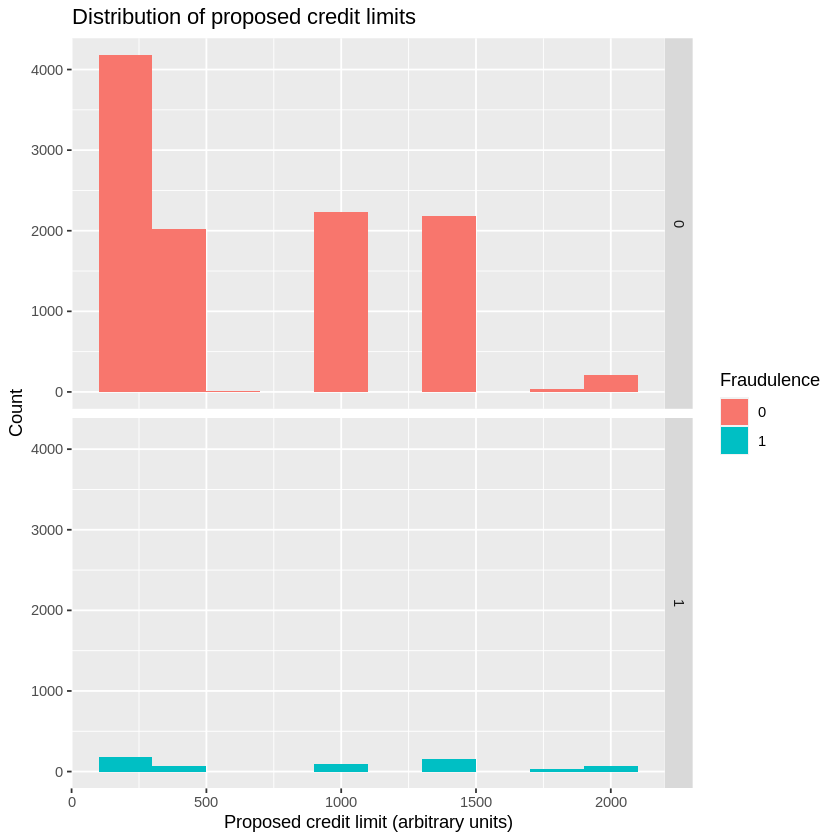

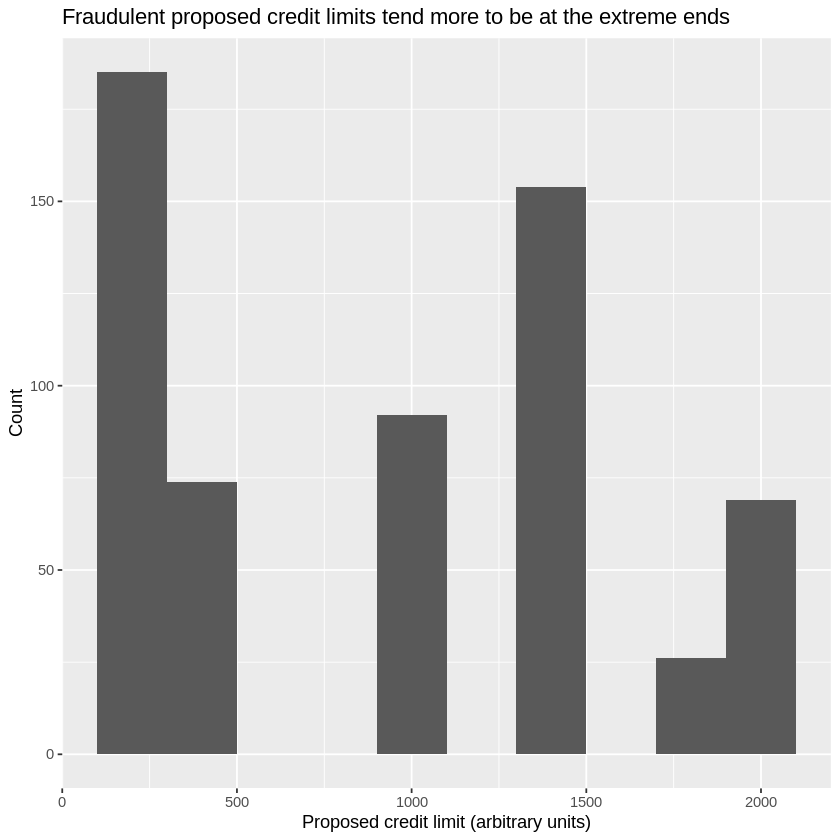

In [13]:
average_proposed_credit_limit <- fraud_train |>
    group_by(fraud_bool) |>
    summarize(proposed_credit_limit = mean(proposed_credit_limit))

proposed_credit_limit_plot <- ggplot(fraud_train, aes(x = proposed_credit_limit, fill = fraud_bool)) +
  geom_histogram(binwidth = 200) +
  labs(fill = "Fraudulence") +
  xlab("Proposed credit limit (arbitrary units)") +
  ylab("Count") +
  facet_grid(rows = vars(fraud_bool)) +
  ggtitle("Distribution of proposed credit limits")

fraud_proposed_credit_limit <- fraud_train |>
  filter(fraud_bool == 1) |>
  ggplot(aes(x = proposed_credit_limit)) +
  geom_histogram(binwidth = 200) +
  xlab("Proposed credit limit (arbitrary units)") +
  ylab("Count") +
  ggtitle("Fraudulent proposed credit limits tend more to be at the extreme ends")

average_proposed_credit_limit
proposed_credit_limit_plot
fraud_proposed_credit_limit

**Insights from the preliminary data exploration:**

- Fraudulent and legitimate bank accounts have similar distributions for session length, credit risk score, and income
- But, they differ for the other 3 variables: months lived at current address, name-email similarity, and proposed credit limit.

Thus, we decided to proceed forward selection with these 3 variables:

- Months lived at current address
- Name-email similarity
- Proposed credit limit

We also learned that legitimate bank accounts (95%) far outnumber fraudulent bank accounts (5%), **so class balancing might be required.**

### 5. Class Balancing
We accounted for the rarity of fraudulent accounts by oversampling fraudulent accounts. We tentatively set the oversampling ratio as 0.25 so that a reasonable amount of computational power would be needed for the next steps.

**Class Balancing**

In [14]:
ups_recipe <- recipe(fraud_bool ~ ., data = fraud_train) |>
  step_upsample(fraud_bool, over_ratio = 0.25, skip = FALSE) |>
  prep()

upsampled_fraud <- bake(ups_recipe, fraud_train)

upsampled_fraud |>
  group_by(fraud_bool) |>
  summarize(n = n())

fraud_bool,n
<fct>,<int>
0,10871
1,2717


### 6. Predictor variable selection with data preprocessing

On the aforementioned 3 variables, we used forward selection algorithm together with recipes that scaled the data. We chose 2 folds for cross-validation to again keep the computational power requirement reasonable.

**Forward selection for predictor variables**

In [15]:
fraud_subset <- upsampled_fraud |>
    select(fraud_bool, current_address_months_count, name_email_similarity,  proposed_credit_limit)

names <- colnames(fraud_subset |> select(-fraud_bool))

accuracies <- tibble(
    size = integer(),
    model_string = character(),
    accuracy = numeric()
)

knn_spec <- nearest_neighbor(
    weight_func = "rectangular",
    neighbors = tune()
) |>
    set_engine("kknn") |>
    set_mode("classification")

fraud_vfold <- vfold_cv(fraud_subset, v = 2, strata = fraud_bool)

n_total <- length(names)

selected <- c()

for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("fraud_bool", "~", paste(preds_new, collapse = "+"))

        # create a recipe from the model string
        fraud_recipe <- recipe(as.formula(model_string),
            data = fraud_subset) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

        # tune the KNN classifier with these predictors,
        # and collect the accuracy for the best K
        acc <- workflow() |>
            add_recipe(fraud_recipe) |>
            add_model(knn_spec) |>
            tune_grid(resamples = fraud_vfold, grid = 5) |>
            collect_metrics() |>
            filter(.metric == "accuracy") |>
            summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
        add_row(
            size = i,
            model_string = models[[jstar]],
            accuracy = accs[[jstar]]
        )
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies


size,model_string,accuracy
<int>,<chr>,<dbl>
1,fraud_bool ~ name_email_similarity,0.9262587
2,fraud_bool ~ name_email_similarity+current_address_months_count,0.9294971
3,fraud_bool ~ name_email_similarity+current_address_months_count+proposed_credit_limit,0.9325145


In [16]:
accuracies_arranged <- accuracies |>
    arrange(desc(accuracy))

accuracies_arranged

size,model_string,accuracy
<int>,<chr>,<dbl>
3,fraud_bool ~ name_email_similarity+current_address_months_count+proposed_credit_limit,0.9325145
2,fraud_bool ~ name_email_similarity+current_address_months_count,0.9294971
1,fraud_bool ~ name_email_similarity,0.9262587


The forward selection algorithm results told us that using all 3 predictor variables would be the best choice, as the accuracy estimate is the highest at 93.3%. It also informed us, however, that the accuracy difference between different choices of predictor variables is small and may be negligible, as the other choices of predictor variables yield similar accuracies of 92.9% and 92.6%.

### 7. Model tuning

First, we specified a recipe to scale and center the data. 

Secondly, we created a KNN model and used 5-fold cross-validation for tuning. 

Lastly, we visualized the results and picked the best K-value. 


**Model tuning to identify the best K**

In [17]:
fraud_recipe <- recipe(fraud_bool ~ name_email_similarity + proposed_credit_limit + current_address_months_count, data = fraud_subset) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

tune_vfold <- vfold_cv(fraud_subset, v = 5, strata = fraud_bool)

knn_results <- workflow() |>
  add_recipe(fraud_recipe) |>
  add_model(tune_spec) |>
  tune_grid(resamples = tune_vfold, grid = 10) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.9687234,5,0.002311748,Preprocessor1_Model1
3,accuracy,binary,0.9135279,5,0.002323809,Preprocessor1_Model2
4,accuracy,binary,0.9135279,5,0.002323809,Preprocessor1_Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,binary,0.8286728,5,0.002857938,Preprocessor1_Model7
13,accuracy,binary,0.8241107,5,0.002444314,Preprocessor1_Model8
14,accuracy,binary,0.8241107,5,0.002444314,Preprocessor1_Model9


**Visualisation of model tuning results**

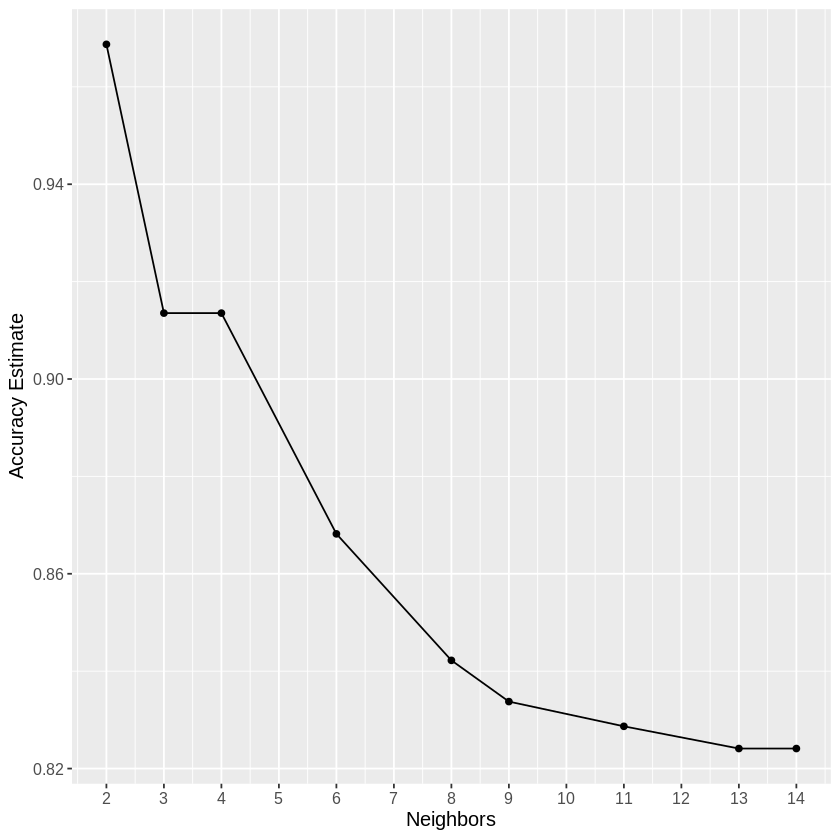

In [18]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12)) +
  scale_x_continuous(breaks=seq(0,14,1))

accuracy_vs_k

Looking at the curve, we saw that **K=1** is the best K-value, as it yields the highest accuracy estimate.

### 8. Obtaining best K-value model

Knowing that the ideal predictor variables are all 3 variables, and that the best K-value is 1, we trained the best K-value model:

**Training of best K-value model**

In [19]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(fraud_recipe) |>
  add_model(knn_spec) |>
  fit(data = fraud_subset)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(1,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.02237268
Best kernel: rectangular
Best k: 1

## Results


**Using the best K-value model to predict on test data**

In [20]:
fraud_test_predictions <- predict(knn_fit, fraud_test) |>
  bind_cols(fraud_test)

fraud_test_predictions

fraud_accuracy <- fraud_test_predictions |>
  metrics(truth = fraud_bool, estimate = .pred_class) |>
  filter(.metric == "accuracy")
fraud_accuracy

.pred_class,fraud_bool,credit_risk_score,income,current_address_months_count,name_email_similarity,session_length_in_minutes,proposed_credit_limit
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,110,0.9,22,0.1595112,2.047904,200
0,1,220,0.9,162,0.6115532,3.531939,200
0,1,143,0.9,186,0.1254526,3.070971,200
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,0,213,0.4,371,0.80050226,34.566322,1500
0,0,266,0.4,141,0.02963662,5.247373,1000
0,0,244,0.8,131,0.86235045,4.555719,1500


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.89409


### 9. Model evaluation against majority classifier

**Comparison with majority classifier**

In [21]:
upsampled_fraud_proportion <- upsampled_fraud |>
                      group_by(fraud_bool) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(upsampled_fraud))
upsampled_fraud_proportion



fraud_bool,n,percent
<fct>,<int>,<dbl>
0,10871,80.00442
1,2717,19.99558


We observed that our classifier has a higher accuracy of 89.4% compared to the 80.0% of the majority classifier. This is a positive sign, as it means that our classifier improved on the majority classifier.

### 10. Visualisation
**Confusion matrix visualisation**

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



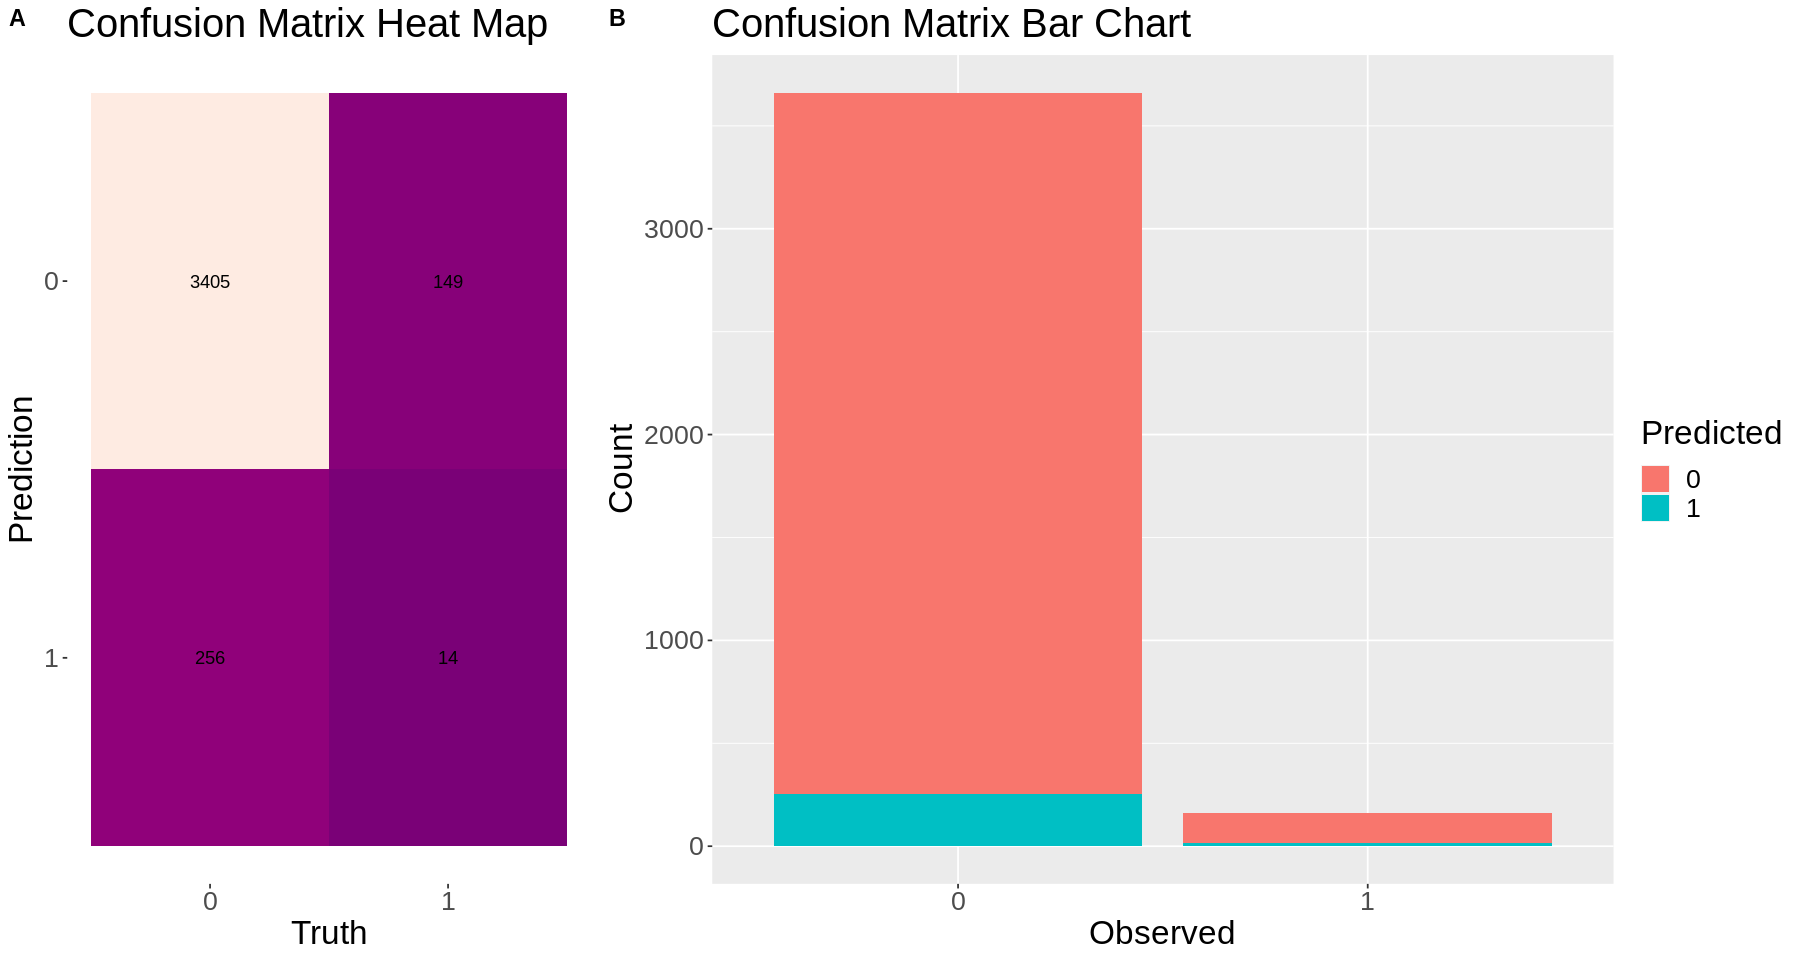

In [22]:
options(repr.plot.width=15, repr.plot.height=8)

fraud_confusion <- fraud_test_predictions |>
             conf_mat(truth = fraud_bool, estimate = .pred_class) |>
                autoplot(type = "heatmap") +
                theme(text = element_text(size = 20)) +
                ggtitle("Confusion Matrix Heat Map") +
                scale_fill_distiller(palette = "RdPu")

fraud_confusion_tibble <- fraud_test_predictions |>
    select(.pred_class, fraud_bool) |>
    table() |>
    as_tibble()

conf_plot <- fraud_confusion_tibble |>
    ggplot(aes(x = fraud_bool, y = n, fill = .pred_class, position = "fill")) +
        geom_bar(stat = "identity") +
        labs(x = "Observed", y = "Count", fill = "Predicted") +
        theme(text = element_text(size = 20)) +
        ggtitle("Confusion Matrix Bar Chart") +
        scale_color_brewer(palette = "RdPu")

plot_grid(fraud_confusion, conf_plot, labels = "AUTO", rel_widths = c(1, 2))


**Insights from the confusion matrix:**
   1. We can see that 256 out of 3661 non-fraudulent accounts were predicted to be fraudulent. 
   2. 93.0% of non-fraudulent accounts were correctly classified, with 7.0% wrongly classified. This 7.0% error is not too big of an issue as accounts predicted to be fraudulent can simply be placed on a watchlist and surveilled more closely.
   3. On the other hand, we can see that 149 out of 163 fraudulent accounts were predicted to be non-fraudulent. 
   4. Only 14 out of 163 fraudulent accounts were identified, which was 8.6% of fraudulent accounts. In other words, 91.4% of fraudulent accounts were undetected by the model. This is a significant drawback for the model as leaving fraudulent accounts undetected has severe consequences due to higher chances of  fraudulent accounts being ultimately undetected by any of the bank's system. This may in turn result in reputational and financial losses for the bank.

Therefore, despite the classifier achieving better results than the majority classifier, this classifier **might not be effective enough** for this application.

## Discussion 


#### Conclusions: 
Our K-nearest neighbors classifier outperformed the majority classifier with an accuracy of 89% compared to 80% in identifying bank account fraud. However, the model only identified 8.6% of fraudulent accounts, leaving 91.4% of them unidentified. The classifier was significantly better at identifying non-fraudulent accounts, with an accuracy of 93.0%. However, this high accuracy may have simply been due to non-fraudulent accounts being 80% of all accounts even after upsampling fraudulent accounts.

We also found through forward selection that the name-email similarity, duration in months lived at current address, and proposed credit limit of applicants may be better indicators of fraudulence than other predictors such as applicants' income and average session length in minutes. However, given the weak accuracy of our model, these predictors must be more thoroughly examined before any conclusions can be made.


#### Expectations: 
All in all, we expected a more effective detection of fraudulent accounts. Although the classifier showed an improvement over the majority classifier, its weak detection rate of 8.6% for fraudulent accounts indicates that it **cannot be used in practice to detect bank account fraud**. 

However, we had also anticipated a low accuracy due to our limited computational power not allowing us to upsample the fraudulent accounts to match the number of non-fraudulent accounts. If this were carried out, perhaps the number of false negatives would decrease and a higher accuracy would have been yielded by our model.

#### Impact of findings: 
The findings suggest that improvements to the model are needed before the classifier be useful in real-world scenarios. The KNN algorithm may be unsuitable for detecting bank fraud, perhaps due to the infrequency of fraudulent accounts compared to non-fraudulent accounts and due to the large volume of data. Other classification algorithms, ones that adapt better to class imbalance and large volumes of data, should be investigated. Furthermore, other predictor variables should also be considered. 

#### Future research questions: 
The results of this project raise several questions for future consideration and research:

a. How do K-nearest neighbor classifiers compare to other classification algorithms, such as convolutional neural networks or naive Bayes, in identifying fraud?

b. Can K-nearest neighbors classifiers be applied to detect other types of fraudulent banking activities, such as phishing scams, debit and credit card fraud, or cheque fraud?

c. Are name-email similarity, duration in months lived at current address, and proposed credit limit of applicants good predictor variables for bank account fraud when using classification algorithms other than KNN? If so, what is the reason for their suitability as predictor variables?

d. How can changing the oversampling ratio of fraudulent bank accounts impact the accuracy of KNN classification models when predicting bank account fraud?

**By addressing these questions, banks and financial institutions can continue to strengthen their fraud detection capabilities and protect their customers from fraudulent activities.**


## References

Jesus, S., Pombal, J., Alves, D., & Cruz, A. F. (2022, November 25). Bank Account Fraud Dataset Suite (neurips 2022). Kaggle.              Retrieved April 13, 2023, from https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022 

Mangala, D. and Soni, L. (2023), "A systematic literature review on frauds in banking sector", Journal of Financial Crime, Vol. 30 No. 1, pp. 285-301. https://doi.org/10.1108/JFC-12-2021-0263

Stephen, M., and Nicholas B. (2017), "Banking and fraud", Computer Law & Security Review, Volume 33, Issue 2, pp. 237-241. https://doi.org/10.1016/j.clsr.2016.11.018.